## Helper functions

In [16]:
"""Imports"""
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from cot import Collection
import yaml

In [3]:
# Helper functions to call OpenAI model, system also generates reasoning
# this function lets the model reason (less frequently used than system_evaluate)

def system_experiment(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\nwith the following answer options:{answer_options}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_generate(input_dict)

def save_as_yaml(data, filepath):
    with open(filepath, 'w') as file:
        yaml.dump(data, file)

In [4]:
def system_evaluate(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\n
    with the following answer options:{answer_options}\n
    Reasoning: {reasoning}\n
    Answer: {answer}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_evals(input_dict)

In [5]:
import pandas as pd
import yaml

def process_new_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    for item in new_data[dataset][split]:
        try:
            scores_per_item.append(yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader))
        except:
            print("wrong output found")
            continue

    # Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys if key != "critique"} #added critique

    #check values for nonetype
    for key, value in scores_per_objective.items():
        if value is not str:
            print(key,value)


    # Calculate the average of each list
    averaged_data = {key: sum(value) / len(value) for key, value in scores_per_objective.items() if key!="critique"} #added critique

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_item, scores_per_objective, df

In [6]:
def parse_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    for item in new_data[dataset][split]:
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            if any(isinstance(v, str) for v in data.values()):
                new_dict = {k: v for k, v in data.items() if k.startswith('obj')}
                scores_per_item.append(new_dict)
                variables_per_item.append(data)
            else:
                scores_per_item.append(data)
        except:
        
            print("wrong output found")
            continue
    return scores_per_item, variables_per_item

In [23]:
#Add minimal value and average value
def parse_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    lowest_obj = []
    for item in new_data[dataset][split]:
        flag = False
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            if any(isinstance(v, str) for v in data.values()):
                new_dict = {k: v for k, v in data.items() if k.startswith('obj')}
                #scores_per_item.append(new_dict)
                flag = True
                variables_per_item.append(data)
        except:
            print("wrong output found")
            continue
        if flag == True:

            data = new_dict
            try:
                # Find the lowest value
                lowest_value = min(data.values())

                # Calculate the average value
                average_value = sum(data.values()) / len(data)

                # Find the key(s) of the lowest value
                lowest_keys = [key for key, value in data.items() if value == lowest_value]     
                lowest_obj.append(lowest_keys)

                # Add lowest and average values to the dictionary
                data['lowest'] = lowest_value
                data['average'] = average_value
            except:
                print("non_int data found... continue")

            scores_per_item.append(data)

    #get lowest keys split for true and false
    item_correct = []

    for item in new_data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = lowest_obj
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]
         
    return scores_per_item, variables_per_item, [scores_true,scores_false]

def count_keys(lst):

    counts = {}
    for item in lst:
        if isinstance(item, list):
            sub_counts = count_keys(item)
            for key, value in sub_counts.items():
                counts[key] = counts.get(key, 0) + value
        else:
            counts[item] = counts.get(item, 0) + 1
    return counts

In [8]:
def parse_lst_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    statements_per_item = []
    for item in new_data[dataset][split]:
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            #if any(isinstance(v, str) for v in data.values()):
            new_dict = {k: v[1] for k, v in data.items() if k.startswith('obj')}
            statement_dict = {k: v[0] for k, v in data.items() if k.startswith('obj')}
            statements_per_item.append(statement_dict)
            scores_per_item.append(new_dict)
            variables_per_item.append(data)
            # else:
            #     scores_per_item.append(data)
        except:
        
            print("wrong output found")
            continue
    return scores_per_item, variables_per_item, statements_per_item


In [9]:
def get_further_data(scores_per_item):
# Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys}
    # scores_per_objective = {k: v for k, v in scores_per_objective.items() if not isinstance(v, str)}
    # print(scores_per_objective)

    # #check values for nonetype
    # for key, value in scores_per_objective.items():
    #     if value is not str:
    #         #print(key,value)
    #         continue


    # Calculate the average of each list
    #averaged_data = {key: sum(value) / len(value) for key, value in scores_per_objective.items()} 
    averaged_data = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in scores_per_objective.items() if len([v for v in value if v is not None]) > 0}

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_objective, df

In [10]:
def fix_none_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if value is None:
                scores_per_item[i][inner_key] = 5
    return scores_per_item
    

In [11]:
def fix_str_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if isinstance(value,str):
                scores_per_item.pop(i)
    return scores_per_item

In [12]:
#helper functions for results
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statistics

def freq_bar_plot(scores_per_item): #later better axes
    average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
    # Create a histogram
    plt.hist(average_per_item, bins='auto', alpha=0.7)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Frequency of average score per item')
    plt.show()

# def avg_item_plot(scores_per_objective):  #later better axes
 
#     data = scores_per_objective
#     averaged_data = {key: sum(value) / len(value) for key, value in data.items() if key!="critique"} #added "critique"
#     sorted_data = {k: v for k, v in sorted(averaged_data.items())}

#     # Extract the keys (objectives) and values (averages) from the sorted dictionary
#     keys = sorted_data.keys()
#     values = sorted_data.values()

#     # Create a bar plot
#     plt.bar(keys, values)
#     plt.xlabel('Objectives')
#     plt.ylabel('Average')
#     # plt.ylim(7,10)
#     plt.title('Average per Objective')
#     plt.xticks(rotation=45)
#     plt.show()

def avg_true_false(data,average_per_item,dataset,split):
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = average_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    print("scores true:", statistics.mean(scores_true))
    print("scores false:", statistics.mean(scores_false))


In [13]:
import math

def standard_deviation(data):
    # First, compute the mean for each key.
    mean_data = {key: sum(value) / len(value) for key, value in data.items()}
    
    # Then, for each key, compute the sum of the squared differences from the mean.
    variance_data = {}
    for key, value in data.items():
        variance_data[key] = sum((x - mean_data[key]) ** 2 for x in value) / (len(value)-1)
    
    # Finally, compute the standard deviation for each key.
    standard_deviation_data = {key: math.sqrt(value) for key, value in variance_data.items()}
    
    return standard_deviation_data

In [14]:
def t_test(data,scores_per_item,dataset,split):
# find which items are correct
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = scores_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    keys = set().union(*scores_true)
        # Create lists of values for each key
    scores_per_objective_true = {key: [d.get(key) for d in scores_true] for key in keys if key != "critique"} 

    keys = set().union(*scores_false)
        # Create lists of values for each key
    scores_per_objective_false = {key: [d.get(key) for d in scores_false] for key in keys if key != "critique"} 

    dict_1 = scores_per_objective_true
    dict_2 = scores_per_objective_false

    # make sure both dictionaries have the same keys
    assert dict_1.keys() == dict_2.keys()

    for key in dict_1.keys():
        t_stat, p_val = ttest_ind(dict_1[key], dict_2[key])
        print(f"For {key}, t-statistic is {t_stat:.2f} and the p-value is {p_val:.2f}")

In [15]:
from scipy.stats import mannwhitneyu

def u_test(data,scores_per_item,dataset,split):
# find which items are correct
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = scores_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    keys = set().union(*scores_true)
        # Create lists of values for each key
    scores_per_objective_true = {key: [d.get(key) for d in scores_true] for key in keys if key != "critique"} 

    keys = set().union(*scores_false)
        # Create lists of values for each key
    scores_per_objective_false = {key: [d.get(key) for d in scores_false] for key in keys if key != "critique"} 

    dict_1 = scores_per_objective_true
    dict_2 = scores_per_objective_false

    # make sure both dictionaries have the same keys
    assert dict_1.keys() == dict_2.keys()

    for key in dict_1.keys():
        u_stat, p_val = mannwhitneyu(dict_1[key], dict_2[key])
        print(f"For {key}, U-statistic is {u_stat:.2f} and the p-value is {p_val:.2f}")
    return scores_per_objective_true,scores_per_objective_false

## Run CoT

In [41]:
from cot import Collection
med_qa = Collection.from_json("med_qa_400.json")

med_qa

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    400 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [ ]:
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "openai_chat",
    "api_time_interval": 1,
    "engine": "gpt-3.5-turbo", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)
med_qa.dump("med_qa_400_turbo")
med_qa.evaluate()
med_qa.dump("med_qa_400_turbo_eval")
med_qa.evaluate()

In [ ]:
# generate cohere
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "cohere",
    "api_time_interval": 1,
    "engine": "command-xlarge-nightly", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)

# med_qa.dump("med_qa_zhou_cohere.json")
# med_qa.evaluate()
# med_qa.dump("med_qa_zhou_cohere.json")

In [31]:
# generate gpt-3.5-turbo
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "openai_chat",
    "api_time_interval": 1,
    "engine": "gpt-3.5-turbo", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)
# med_qa.dump("med_qa_zhou.json")
# med_qa.evaluate()
# med_qa.dump("med_qa_zhou_eval.json")

Generating med_qa...


In [42]:
from cot import Collection
# med_qa = Collection.from_json("med_qa_400.json")

# generate gpt-4
config={
    "instruction_keys": None,
    "cot_trigger_keys": ["zhou-01"],
    "answer_extraction_keys": 'auto-kojima', 
    "author" : "thoughtsource",
    "api_service": "openai_chat",
    "api_time_interval": 1,
    "engine": "gpt-4", 
    "temperature": 0,
    "max_tokens": 512,
    "verbose": False,
    "warn": False,
}
med_qa.generate(config=config)

med_qa.dump("med_qa_400_gpt4.json")
med_qa.evaluate()
med_qa.dump("med_qa_400_eval_gpt4.json")

med_qa.evaluate()

Generating med_qa...


  0%|          | 0/400 [00:00<?, ?ex/s]

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Request failed due to server shutdown {
  "error": {
    "message": "Request failed due to server shutdown",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'Request failed due to server shutdown', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Fri, 02 Jun 2023 21:49:42 GMT', 'Content-Type': 'application/json', 'Content-Length': '141', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-4-0314', 'openai-organization': 'medical-university-of-vienna', 'openai-processing-ms': '32142', 'openai-version': '2020-10-01', 'strict-transport-security': 'max-age=15724800; includeSubDomains', 'x-ratelimit-limit-requests': '200', 'x-ratelimit-limit-tokens': '40000', 'x-ratelimit-remaining-requests': '199', 'x-ratelimit-remaining-tokens': '39192', 'x-ratelimit-rese

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/400 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/400 [00:00<?, ?ex/s]

{'med_qa': {'test': {'accuracy': {'gpt-4': {'None_zhou-01_kojima-A-E': 0.785}}}}}

## Template

In [43]:
path = "./final_system_messages/first_template.yaml"

## Run reflection

In [ ]:
# 3.5 on 3.5
data = med_qa
model = 'gpt-3.5-turbo'
system_evaluate(data,model,path)

dataset_name = "med_qa"
template = "first"
base_model = "gpt-3.5-turbo"
critique_model = "gpt-3.5-turbo"

dump_path = f"{dataset_name}_{template}_{base_model}_{critique_model}"
data.dump(dump_path+".json")

In [ ]:
#Other reflection were run in big_reflection_experiments.ipynb

## Evaluate reflection

non_int data found... continue


Average over objectives for all items
          Average
obj_1   90.388471
obj_2   96.328321
obj_3   92.431078
obj_4   89.498747
obj_5   83.972431
obj_6   86.102757
obj_7   85.463659
obj_8   92.481203
obj_9   76.566416
obj_10  87.719298
obj_11  96.027569


Average over objectives separated by items with correct / incorrect answers
scores true: 87.81802592312147
scores false: 87.57424928013164


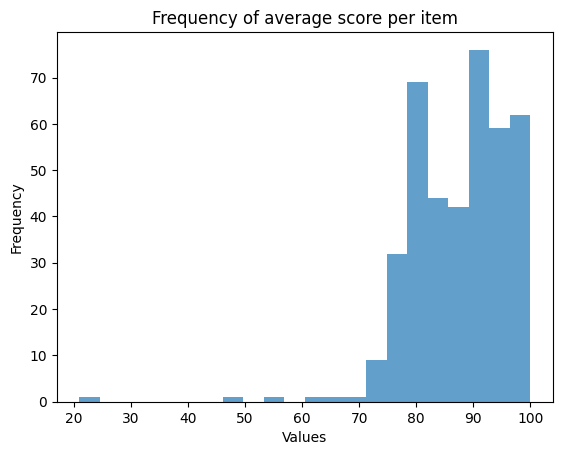

Mann-Whitney-U test
For obj_2, U-statistic is 13444.50 and the p-value is 0.90
For obj_8, U-statistic is 13692.00 and the p-value is 0.69
For obj_5, U-statistic is 13697.00 and the p-value is 0.70
For obj_3, U-statistic is 13604.50 and the p-value is 0.77
For obj_4, U-statistic is 14296.50 and the p-value is 0.29
For average, U-statistic is 13842.00 and the p-value is 0.60
For obj_7, U-statistic is 14019.00 and the p-value is 0.46
For obj_10, U-statistic is 13905.50 and the p-value is 0.53
For obj_9, U-statistic is 13974.50 and the p-value is 0.48
For obj_11, U-statistic is 14026.00 and the p-value is 0.37
For obj_1, U-statistic is 12891.50 and the p-value is 0.61
For lowest, U-statistic is 13375.00 and the p-value is 0.97
For obj_6, U-statistic is 13857.00 and the p-value is 0.57


Frequency where objective is lowest scored for items with false answer
{'obj_9': 80, 'obj_5': 30, 'obj_7': 20, 'obj_6': 14, 'obj_3': 11, 'obj_10': 11, 'obj_4': 10, 'obj_1': 10, 'obj_2': 9, 'obj_8': 9, 'obj_

In [31]:
#GPT-4 supervised by GPT-3.5

data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-3.5-turbo.json")
#data_100 = Collection.from_json("./med_qa_first_gpt-4_gpt-3.5-turbo.json")
#data_500 = data_400.merge(data_100)
data = data_400 #data_500 #is still running

scores_per_item, variables_per_item, [scores_true,scores_false] = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
print("\n")
print("Average over objectives for all items")
print(df)
print("\n")

print("Average over objectives separated by items with correct / incorrect answers")
avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false = u_test(data,scores_per_item,'med_qa','test')
print("\n")
print("Frequency where objective is lowest scored for items with false answer")
print(dict(sorted(count_keys(scores_false).items(), key=lambda x: -x[1])))
print("\n")
print("Frequency where objective is lowest scored for items with correct answer")
print(dict(sorted(count_keys(scores_true).items(), key=lambda x: -x[1])))
print("\n")

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

non_int data found... continue


Average over objectives for all items
          Average
obj_1   95.861723
obj_2   91.382766
obj_3   97.224449
obj_4   90.420842
obj_5   92.314629
obj_6   90.961924
obj_7   83.967936
obj_8   89.088176
obj_9   86.132265
obj_10  92.104208
obj_11  89.498998


Average over objectives separated by items with correct / incorrect answers
scores true: 93.79025736168593
scores false: 83.5609756097561


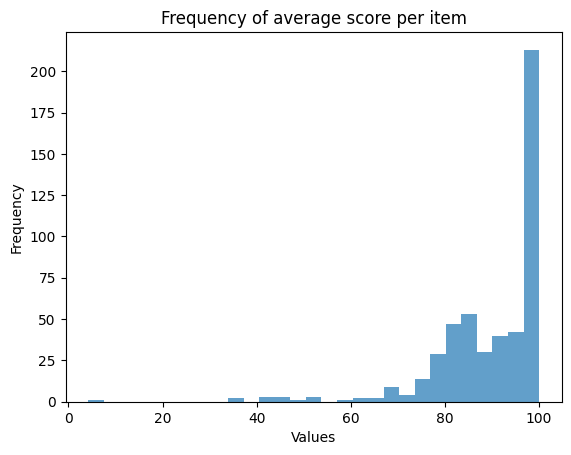

Mann-Whitney-U test
For obj_2, U-statistic is 44421.50 and the p-value is 0.00
For obj_8, U-statistic is 48145.00 and the p-value is 0.00
For obj_5, U-statistic is 39804.00 and the p-value is 0.00
For obj_3, U-statistic is 32299.00 and the p-value is 0.03
For obj_4, U-statistic is 44255.50 and the p-value is 0.00
For average, U-statistic is 46403.00 and the p-value is 0.00
For obj_7, U-statistic is 41448.50 and the p-value is 0.00
For obj_10, U-statistic is 43424.50 and the p-value is 0.00
For obj_9, U-statistic is 34992.50 and the p-value is 0.00
For obj_11, U-statistic is 40116.00 and the p-value is 0.00
For obj_1, U-statistic is 38099.50 and the p-value is 0.00
For lowest, U-statistic is 47547.00 and the p-value is 0.00
For obj_6, U-statistic is 41815.50 and the p-value is 0.00


Frequency where objective is lowest scored for items with false answer
{'obj_7': 98, 'obj_9': 73, 'obj_11': 69, 'obj_8': 36, 'obj_4': 20, 'obj_5': 20, 'obj_2': 19, 'obj_10': 15, 'obj_6': 15, 'obj_3': 13, 'o

In [27]:
#GPT-3.5 supervised by GPT-4

data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-4.json")
data_500 = data_400.merge(data_100)
data = data_500

scores_per_item, variables_per_item, [scores_true,scores_false] = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
print("\n")
print("Average over objectives for all items")
print(df)
print("\n")

print("Average over objectives separated by items with correct / incorrect answers")
avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false = u_test(data,scores_per_item,'med_qa','test')
print("\n")
print("Frequency where objective is lowest scored for items with false answer")
print(dict(sorted(count_keys(scores_false).items(), key=lambda x: -x[1])))
print("\n")
print("Frequency where objective is lowest scored for items with correct answer")
print(dict(sorted(count_keys(scores_true).items(), key=lambda x: -x[1])))
print("\n")

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

wrong output found
non_int data found... continue
Average over objectives for all items
          Average
obj_1   88.878866
obj_2   95.399485
obj_3   90.244845
obj_4   87.641753
obj_5   82.074742
obj_6   85.141753
obj_7   84.033505
obj_8   91.481959
obj_9   77.010309
obj_10  86.881443
obj_11  94.948454


Average over objectives separated by items with correct / incorrect answers
scores true: 87.38292011019284
scores false: 85.61378112333527


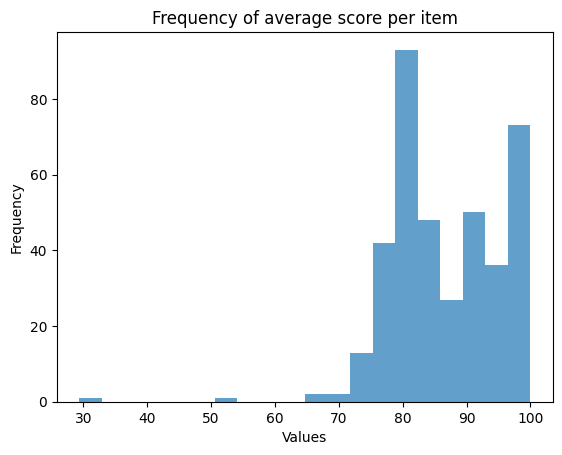

Mann-Whitney-U test
For obj_2, U-statistic is 19469.00 and the p-value is 0.15
For obj_8, U-statistic is 20166.50 and the p-value is 0.04
For obj_5, U-statistic is 19566.50 and the p-value is 0.17
For obj_3, U-statistic is 20019.00 and the p-value is 0.07
For obj_4, U-statistic is 20207.00 and the p-value is 0.04
For average, U-statistic is 19986.50 and the p-value is 0.09
For obj_7, U-statistic is 18679.00 and the p-value is 0.60
For obj_10, U-statistic is 19441.50 and the p-value is 0.20
For obj_9, U-statistic is 18831.50 and the p-value is 0.50
For obj_11, U-statistic is 19450.50 and the p-value is 0.16
For obj_1, U-statistic is 20060.50 and the p-value is 0.06
For lowest, U-statistic is 20107.50 and the p-value is 0.06
For obj_6, U-statistic is 18943.00 and the p-value is 0.43


Frequency where objective is lowest scored for items with false answer
{'obj_9': 140, 'obj_5': 77, 'obj_7': 47, 'obj_6': 29, 'obj_3': 26, 'obj_4': 25, 'obj_1': 22, 'obj_11': 20, 'obj_8': 18, 'obj_10': 18, '

In [24]:
#GPT-3.5 supervised by GPT-3.5

data_400 = Collection.from_json("./med_qa_400_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
data_100 = Collection.from_json("./med_qa_first_gpt-3.5-turbo_gpt-3.5-turbo.json")
data_500 = data_400.merge(data_100)
data = data_500

scores_per_item, variables_per_item, [scores_true,scores_false] = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
print("\n")
print("Average over objectives for all items")
print(df)
print("\n")

print("Average over objectives separated by items with correct / incorrect answers")
avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false = u_test(data,scores_per_item,'med_qa','test')
print("\n")
print("Frequency where objective is lowest scored for items with false answer")
print(dict(sorted(count_keys(scores_false).items(), key=lambda x: -x[1])))
print("\n")
print("Frequency where objective is lowest scored for items with correct answer")
print(dict(sorted(count_keys(scores_true).items(), key=lambda x: -x[1])))
print("\n")

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Average over objectives for all items
        Average
obj_1     99.45
obj_2     97.65
obj_3     99.82
obj_4     98.24
obj_5     99.09
obj_6     98.41
obj_7     89.90
obj_8     97.78
obj_9     92.97
obj_10    98.96
obj_11    97.78


Average over objectives separated by items with correct / incorrect answers
scores true: 97.20173497388687
scores false: 94.15584415584416


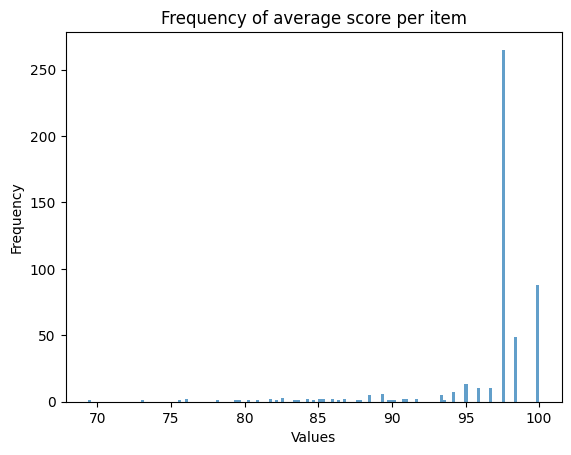

Mann-Whitney-U test
For obj_2, U-statistic is 24847.50 and the p-value is 0.00
For obj_8, U-statistic is 25495.50 and the p-value is 0.00
For obj_5, U-statistic is 22624.50 and the p-value is 0.00
For obj_3, U-statistic is 20883.00 and the p-value is 0.31
For obj_4, U-statistic is 24507.50 and the p-value is 0.00
For average, U-statistic is 26231.50 and the p-value is 0.00
For obj_7, U-statistic is 25066.50 and the p-value is 0.00
For obj_10, U-statistic is 23527.50 and the p-value is 0.00
For obj_9, U-statistic is 20835.50 and the p-value is 0.93
For obj_11, U-statistic is 22806.00 and the p-value is 0.00
For obj_1, U-statistic is 22583.00 and the p-value is 0.00
For lowest, U-statistic is 25841.50 and the p-value is 0.00
For obj_6, U-statistic is 24844.00 and the p-value is 0.00


Frequency where objective is lowest scored for items with false answer
{'obj_7': 92, 'obj_9': 60, 'obj_11': 24, 'obj_2': 18, 'obj_8': 17, 'obj_6': 16, 'obj_5': 15, 'obj_4': 14, 'obj_3': 13, 'obj_10': 13, 'o

In [19]:
# GPT-4 supervised by GPT-4
data_400 = Collection.from_json("./med_qa_400_first_gpt-4_gpt-4.json")
data_100 = Collection.from_json("./med_qa_first_gpt-4_gpt-4.json")
data_500 = data_400.merge(data_100)
data = data_500
print("\n")
scores_per_item, variables_per_item, [scores_true,scores_false] = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print("Average over objectives for all items")
print(df)
print("\n")

print("Average over objectives separated by items with correct / incorrect answers")
avg_true_false(data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
# avg_item_plot(scores_per_objective)

print("Mann-Whitney-U test")
scores_per_objective_true,scores_per_objective_false = u_test(data,scores_per_item,'med_qa','test')
print("\n")
print("Frequency where objective is lowest scored for items with false answer")
print(dict(sorted(count_keys(scores_false).items(), key=lambda x: -x[1])))
print("\n")
print("Frequency where objective is lowest scored for items with correct answer")
print(dict(sorted(count_keys(scores_true).items(), key=lambda x: -x[1])))
print("\n")

range_data = {key: (min(value),max(value)) for key, value in scores_per_objective.items()}
print("range of scores")
print(range_data)
print("\n")
print("Standard dev. of scores")
print(standard_deviation(scores_per_objective))